In [27]:
import torch
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module
from torch.optim import Adam
from torch import nn,optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
trans = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
#( note: the ToTensor() transform automatically normalizes the images by dividing by 255)

# ImageFolder is a generic data loader where the images are arranged inside the root_directory with different folders for each category

train = ImageFolder('DevanagariHandwrittenCharacterDataset/train', transform=trans, loader=lambda path: Image.open(path).convert("LA"))
test = ImageFolder('DevanagariHandwrittenCharacterDataset/test', transform=trans,loader=lambda path: Image.open(path).convert("LA"))
# (note: ImageFolder's default loader loads RGB images by default, since we have Grayscale images we are using a custom loader here.)

train_loader = DataLoader(train, batch_size=100, shuffle=True)
test_loader = DataLoader(test, batch_size=100, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layer = Sequential(
            # Defining a 2D convolution layer with 5x5 kernels, 0 padding, 1 stride
            # => output image size = ((32-5+0)/1)+1 = 28x28
            Conv2d(1,32,kernel_size=(5,5)),
            
            # with RELU activation
            ReLU(inplace=True),
            
            # add a Pooling layer with 2x2 kernels
            # => output image size 28/2 = 14x14
            MaxPool2d(2))   
        
        # A fully connected layer with 128 kernels (image size 14x14)
        self.fc1=Linear(32*14*14,128)
        
        # Output layer with 46 outputs for the 46 categories
        self.fc2=Linear(128,46)


    # Defining the forward pass    
    def forward(self, x):
        
        # perform the convolution and pooling
        out = self.cnn_layer(x)
        
        # flatten the output
        out = out.reshape(out.size(0), -1)
        
        # pass through the fully connected layers
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out


model=Net()
model.to(device)


Net(
  (cnn_layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=46, bias=True)
)

In [29]:
learning_rate=0.0001

# using crossentropy loss for categorical inputs
criterion = torch.nn.CrossEntropyLoss()

# using Adam optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

#Reduce learning rate lr by a factor of 0.1 every 7 epochs
step_lr = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#Training
total_step = len(train_loader)
nb_epoch=10
    


#train_losses=[]
#val_losses=[]

test_loss_epoch = []
test_accuracy = []
train_loss_epoch = []
train_accuracy = []

for epoch in range(nb_epoch):
    
    train_acc = 0
    test_acc = 0
    train_loss = []
    test_loss = []
    
    
    model.train()
    
    with torch.set_grad_enabled(True):
        for i, (images, labels) in enumerate(train_loader):
            inputs = images.to(device)
            targets = labels.to(device)

            # clearing the Gradients of the model parameters
            optimizer.zero_grad()

            # prediction for training and validation set
            output = model(inputs)
            # compute cross entropy loss
            loss = criterion(output, targets)
            # predict the class using the index of the maximum value from the output 
            _, pred = torch.max(output, 1)

            train_acc += torch.sum(targets == pred)

            # Backpropagate and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.detach().cpu().numpy())
            
            # print the loss every 100 training batches
            if i%100 == 0:
                print('Iteration {} in Epoch {} Train Loss: {}'.format(i, epoch, loss))
                
    model.eval()
    
    with torch.set_grad_enabled(False):
        for i, (images, labels) in enumerate(test_loader):
            inputs_test = images.to(device)
            targets_test = labels.to(device)

            output = model(inputs_test)
            # Compute cross entropy loss
            loss_test = criterion(output, targets_test)
            # predict the class using the index of the maximum value from the output 
            _, pred = torch.max(output, 1)
            test_acc += torch.sum(targets_test == pred)
            test_loss.append(loss_test.detach().cpu().numpy())
            
    # append the average values of the training loss, training accuracy, test loss and test accuracy per epoch
    train_loss_epoch.append(sum(train_loss)/len(train_loader))
    test_loss_epoch.append(sum(test_loss)/len(test_loader))
    train_accuracy.append(train_acc.cpu().numpy()/len(train))
    test_accuracy.append(test_acc.cpu().numpy()/len(test))
    
    # print the average values of the training loss, training accuracy, test loss and test accuracy for every epoch
    print('Epoch: {}, Train Loss: {} Train Accuracy: {}// Test Loss: {} Test Accuracy: {}'.format(epoch, sum(train_loss)/len(train_loader), train_acc.cpu().numpy()/len(train), sum(test_loss)/len(test_loader), test_acc.cpu().numpy()/len(test)))
            
    #Change learning rate every seven epochs
    step_lr.step()
    

/Users/kiranlakhchaura/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Iteration 0 in Epoch 0 Train Loss: 3.8521735668182373
Iteration 100 in Epoch 0 Train Loss: 1.9340386390686035
Iteration 200 in Epoch 0 Train Loss: 1.2203058004379272
Iteration 300 in Epoch 0 Train Loss: 0.9401977062225342
Iteration 400 in Epoch 0 Train Loss: 1.0061025619506836
Iteration 500 in Epoch 0 Train Loss: 0.9817346930503845
Iteration 600 in Epoch 0 Train Loss: 0.7003145813941956
Iteration 700 in Epoch 0 Train Loss: 0.7278165221214294
Epoch: 0, Train Loss: 1.147785053609887 Train Accuracy: 0.7123529411764706// Test Loss: 0.5824698645729518 Test Accuracy: 0.845072463768116
Iteration 0 in Epoch 1 Train Loss: 0.4528562128543854
Iteration 100 in Epoch 1 Train Loss: 0.6041050553321838
Iteration 200 in Epoch 1 Train Loss: 0.36373427510261536
Iteration 300 in Epoch 1 Train Loss: 0.4623102843761444
Iteration 400 in Epoch 1 Train Loss: 0.4758194088935852
Iteration 500 in Epoch 1 Train Loss: 0.42627865076065063
Iteration 600 in Epoch 1 Train Loss: 0.43297886848449707
Iteration 700 in Epoc

### Loss plots for training and test sets

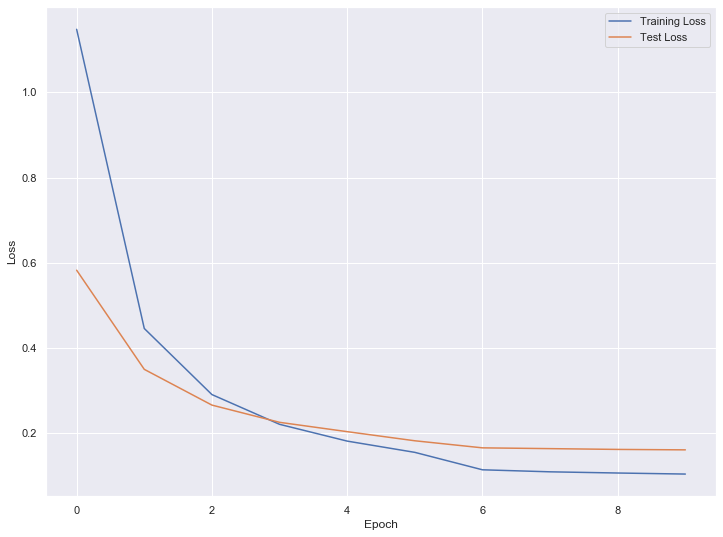

In [31]:
import seaborn as sns

sns.set()
fig, ax = plt.subplots(1, 1, figsize = (12, 9))
ax.plot(train_loss_epoch, label='Training Loss')
ax.plot(test_loss_epoch, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='best')
fig.savefig('devnagari_alphabet_recognition_loss_inception_net.png', dpi=300)

### Accuracy plots for training and test sets

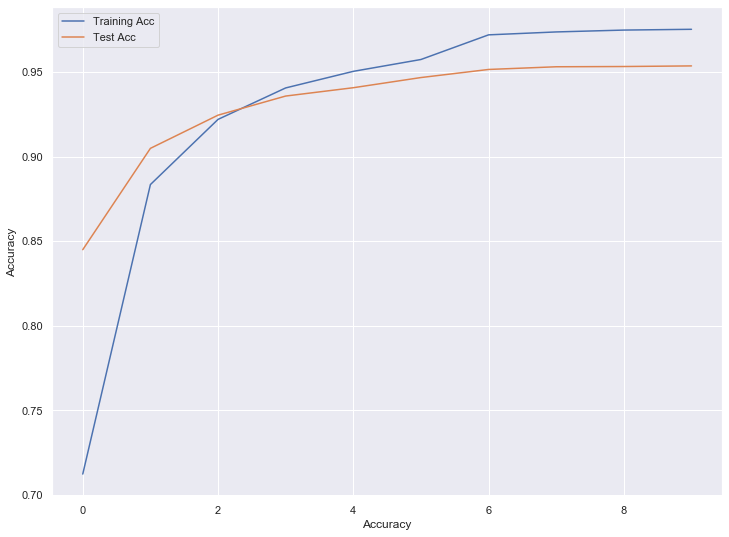

In [32]:
fig1, ax1 = plt.subplots(1, 1, figsize = (12, 9))
ax1.plot(train_accuracy, label='Training Acc')
ax1.plot(test_accuracy, label='Test Acc')
ax1.set_xlabel('Accuracy')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='best')
fig1.savefig('devnagari_alphabet_recognition_accuracy_inception_net.png', dpi=300)

In [108]:
# test for example image

tensor([17]) character_26_yaw


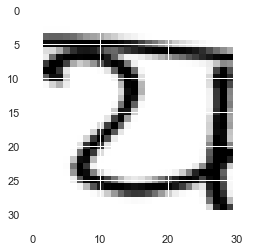

In [111]:
file = 'DevanagariHandwrittenCharacterDataset/test/character_26_yaw/10528.png'
img = Image.open(file).convert("L")
plt.imshow(np.asarray(img),cmap='gray_r')
img = transforms.Normalize((0.1307,), (0.3081,))(transforms.ToTensor()(img))
img = img.unsqueeze(0)
img.size()
_, pred = torch.max(model(img), 1)
print(pred,train.classes[pred])

Thus, the classification seems to be right.